In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import os

from fredapi import Fred
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### Instantianting fred object

In [2]:
fred = Fred(api_key='0b9b641528f6d36f68446b8e833c119d')a

#### Getting data 
-  how to choose data, should I put everything that I think has an influence on the output?


In [3]:
wti = fred.get_series('DCOILWTICO', observation_start='1/31/2008')
wti.tail()

2020-01-07    62.70
2020-01-08    59.65
2020-01-09    59.56
2020-01-10    59.02
2020-01-13    58.17
dtype: float64

In [4]:
brent= fred.get_series('DCOILBRENTEU', observation_start='1/31/2008')

In [5]:
inflation = fred.get_series('T10YIE', observation_start='1/31/2008')
inflation.tail()

2020-01-16    1.74
2020-01-17    1.75
2020-01-20     NaN
2020-01-21    1.74
2020-01-22    1.72
dtype: float64

In [6]:
data = pd.concat([wti, inflation, brent], axis=1)

In [7]:
data.columns = ["wti", "brent", "inflation"] 

In [8]:
data.dropna(axis=0, inplace=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11cca9b70>,
      dtype=object)

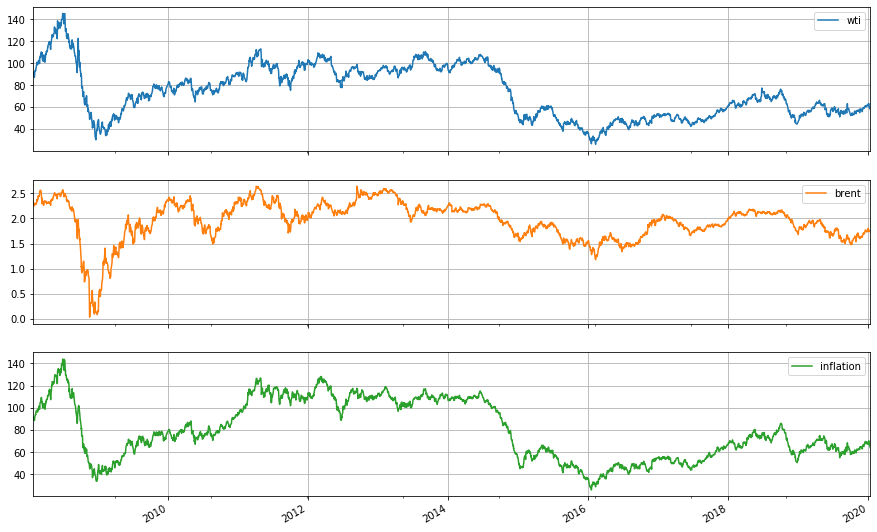

In [9]:
data.plot(subplots=True, grid=True, figsize = (15,10))

<Figure size 1080x1080 with 0 Axes>

<Figure size 1080x1080 with 0 Axes>

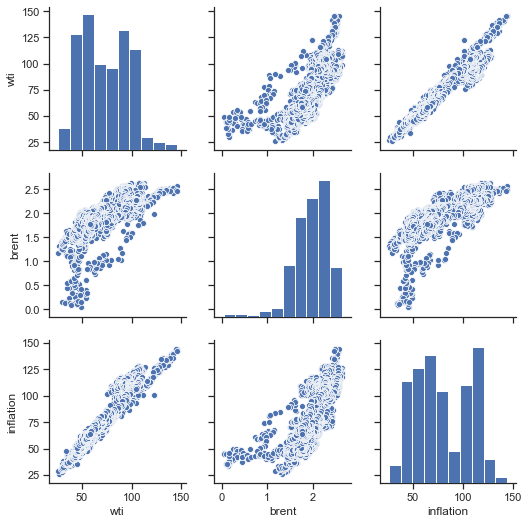

In [68]:
import seaborn as sns
sns.set(style="ticks")


sns.pairplot(data)

#### Splitting data and defining hyperparameters

In [55]:
percentage_test = 0.1


# defining the batch size and number of epochs
batch_size = 60 # This is about three month of data
epochs = 10
timesteps =1

In [56]:
n_data = len(data)
train_length = int(n_data * (1 - percentage_test) / batch_size) * batch_size + timesteps
test_length  = int((n_data - train_length)/batch_size) * batch_size 
train = data.iloc[0:train_length].values
test = data.iloc[train_length:train_length + test_length + 1].values

In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))
yscaler = MinMaxScaler(feature_range = (0, 1))

scaler.fit(train)
yscaler.fit(train[:,-1].reshape(len(train),1))

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

MinMaxScaler(copy=True, feature_range=(0, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

#### Lagging input (for AR component of the model), shiftint output for 1D prediction

In [58]:
def create_data(scaled_data, timesteps):
    x = []
    y = []
    for t in range(timesteps, len(scaled_data)):
        x.append(scaled_data[t - timesteps:t, :])
        y.append(scaled_data[t, -1])

    x, y = np.array(x), np.array(y)
    
    # Reshaping, LSTM inputs requires to be in format (nsamples, timesteps, dim)
    x = np.reshape(x, (scaled_data.shape[0] -1, timesteps, scaled_data.shape[1]))
    
    return x, y
    

In [59]:
x_train, y_train = create_data(train_scaled, timesteps)
x_test, y_test = create_data(test_scaled, timesteps)

#### Initialising the LSTM Model with MAE Loss-Function

To discuss:
1. there are different way of training the LSTM, stateful LSTM allows to memorize the states at each epoch, the following way to train an NN is considered better as it considers better time dependency. This is using a functional design.
2. other design
3. droupout rate?

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input, LSTM, Dropout, Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.callbacks import TensorBoard, History, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import h5py


#sess = tf.InteractiveSession()
#tf.global_variables_initializer().run()

In [62]:
inputs_1_mae = Input(batch_shape = (batch_size, timesteps, x_train.shape[2]))

# each layer is the input of the next layer
lstm_1_mae = LSTM(10, stateful=True, return_sequences=True)(inputs_1_mae)
lstm_1_mae = Dropout(0.2)(lstm_1_mae)
lstm_2_mae = LSTM(10, stateful=True, return_sequences=True)(lstm_1_mae)
lstm_2_mae = Dropout(0.2)(lstm_2_mae)
lstm_2_mae = Flatten()(lstm_2_mae)
output_1_mae = Dense(units = 1)(lstm_2_mae)

regressor_mae = Model(inputs=inputs_1_mae, outputs = output_1_mae)

regressor_mae.compile(optimizer='adam', loss = 'mae')
regressor_mae.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(60, 1, 3)]              0         
_________________________________________________________________
lstm_6 (LSTM)                (60, 1, 10)               560       
_________________________________________________________________
dropout_6 (Dropout)          (60, 1, 10)               0         
_________________________________________________________________
lstm_7 (LSTM)                (60, 1, 10)               840       
_________________________________________________________________
dropout_7 (Dropout)          (60, 1, 10)               0         
_________________________________________________________________
flatten_3 (Flatten)          (60, 10)                  0         
_________________________________________________________________
dense_3 (Dense)              (60, 1)                   11  

#### Create callback

In [63]:
model_name = "2_10_hidden_adam_mae"

# Create a TensorBoard logger
logger = TensorBoard(
    log_dir='logs/{}'.format(model_name),
    #write_graph=True,
    histogram_freq=5
)
history = History()
early_stopper = EarlyStopping(min_delta=0.0001, patience=50)

checkpointer = ModelCheckpoint(os.path.join("results", model_name), save_best_only=True, verbose=0)

#### Run training

In [64]:
# Statefull

for i in range(epochs):
    
    print("Epoch: " + str(i))
    
    # run through all data but the cell, hidden state are used for the next batch.
    regressor_mae.fit(x_train, y_train, 
                      shuffle=False, 
                      epochs = 1, 
                      batch_size = batch_size,
                      callbacks=[logger, early_stopper, history],
                      validation_data=(x_test, y_test)
                     ) #validation_split=0.20 
    
    # resets only the states but the weights, cell and hidden are kept.
    regressor_mae.reset_states()

Epoch: 0
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 2s 855us/sample - loss: 0.3621 - val_loss: 0.1197


Epoch: 1
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 45us/sample - loss: 0.2620 - val_loss: 0.1479


Epoch: 2
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 46us/sample - loss: 0.2381 - val_loss: 0.0956


Epoch: 3
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 41us/sample - loss: 0.2368 - val_loss: 0.0718


Epoch: 4
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 41us/sample - loss: 0.2289 - val_loss: 0.0710


Epoch: 5
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 42us/sample - loss: 0.2141 - val_loss: 0.0523


Epoch: 6
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 45us/sample - loss: 0.2034 - val_loss: 0.0485


Epoch: 7
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 44us/sample - loss: 0.1964 - val_loss: 0.0567


Epoch: 8
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 42us/sample - loss: 0.1813 - val_loss: 0.0501


Epoch: 9
Train on 2640 samples, validate on 300 samples
2640/2640 [==============================] - 0s 42us/sample - loss: 0.1749 - val_loss: 0.0587


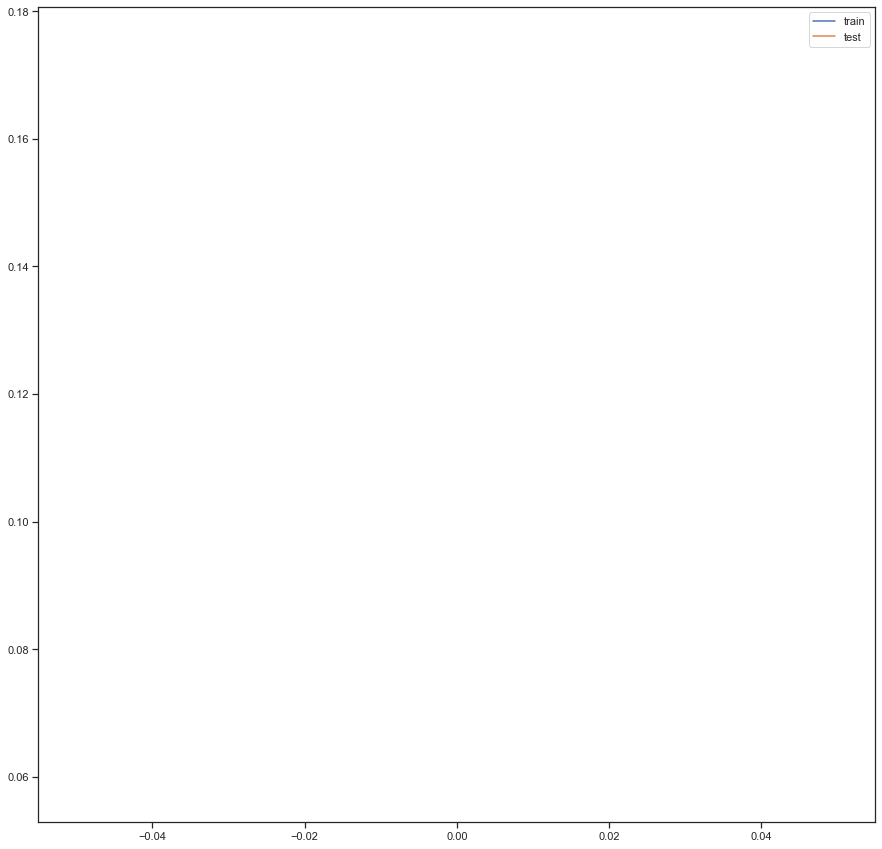

In [69]:
# plot history
fig = plt.figure(figsize=(15,15))
plt.plot(regressor_mae.history.history['loss'], label='train')
plt.plot(regressor_mae.history.history['val_loss'], label='test')
plt.grid()
plt.legend()

plt.grid()

In [33]:
#prediction
y_predicted_test = regressor_mae.predict(x_test, batch_size=batch_size)
regressor_mae.reset_states()

In [34]:
y_predicted_test_values = yscaler.inverse_transform(y_predicted_test).flatten()
y_test_values = yscaler.inverse_transform(y_test.reshape(len(y_test),1)).flatten()

Text(0.5, 1.0, 'Crude Oil Prices Prediction - MAE')

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Crude Oil Prices')

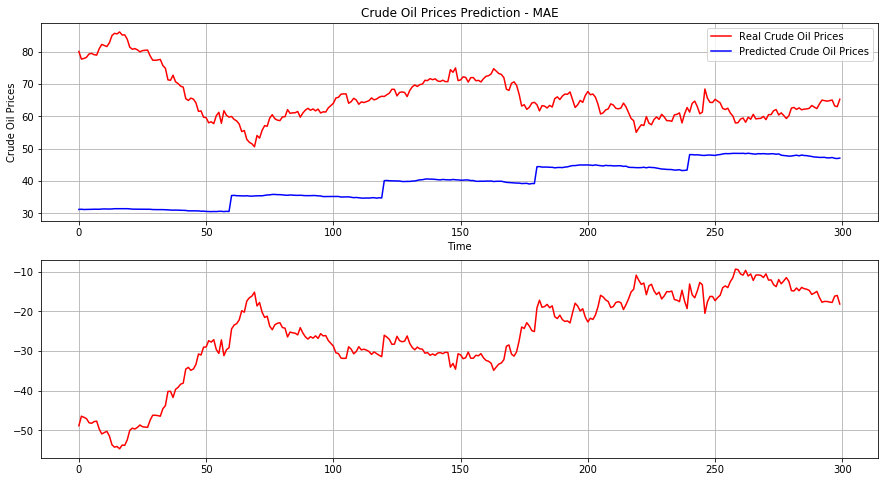

In [35]:
# Visualising the results
fig = plt.figure(figsize=(15, 8))
plt.subplot(211)
plt.plot(y_test_values, color = 'red', label = 'Real Crude Oil Prices')
plt.plot(y_predicted_test_values, color = 'blue', label = 'Predicted Crude Oil Prices')
plt.title('Crude Oil Prices Prediction - MAE')
plt.xlabel('Time')
plt.ylabel('Crude Oil Prices')
plt.legend()
plt.grid()

plt.subplot(212)
plt.plot(y_predicted_test_values - y_test_values, color = 'red', label = 'Error')
plt.grid()
plt.show()

In [36]:
test_error_rate = regressor_mae.evaluate(x_test, y_test, verbose=0)
print("The mean squared error (MSE) for the test data set is: {}".format(test_error_rate))

The mean squared error (MSE) for the test data set is: 0.22025647461414338
